In [7]:
# !pip install transformers datasets
# !pip install torch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from torch.utils.data import DataLoader
from transformers import BertTokenizer

/opt/anaconda3/envs/compsci371/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import the Dataset, and create training and testing splits. Here I am only using 5% of the entire corpus for each respective training and testing, as my computer cant handle large datasets. 

### I am using BertTokenizer from huggingface, which breaks the corpus of text into words and subwords, and maps them to corresponding numerical IDs.
### I reveal that the vocab size is 30,522

In [40]:
sentiment = load_dataset("yelp_polarity")
tr = sentiment['train']
ts = sentiment['test']
tr = tr.train_test_split(test_size=0.95)['train']
ts = ts.train_test_split(test_size=0.95)['train']


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(data):
    return tokenizer(data['text'], padding='max_length', truncation=True)

tokenized_dataset = tr.map(tokenize_function, batched=True)

word_count = tokenizer.vocab_size
print("Vocab Size:", word_count)

Map: 100%|████████████████████████| 28000/28000 [00:56<00:00, 499.30 examples/s]

Vocab Size: 30522


### Example of what the tokenizer returns

In [45]:
tokenizer("NLP is fun!")

{'input_ids': [101, 17953, 2361, 2003, 4569, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

### Here I load the datasets into DataLoader objects which make it possible to batch the data in the training phase.

In [43]:
batch_size = 8

tr = tr.map(tokenize_function, batched=True)
tr.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)

ts = ts.map(tokenize_function, batched=True)
ts.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
ts_loader = DataLoader(ts, batch_size=batch_size, shuffle=False)

Map: 100%|██████████████████████████| 1900/1900 [00:03<00:00, 526.01 examples/s]


### This is our model, which uses a word embedding layer to represent each word in a 10 dimensional vector, and then is averaged together across all embeddings in the sentance to form a single vector.finally is fed forward into a fully connected layer which outputs one logit, representing Positive or Negative sentiment.

In [5]:
class LinearRegression(nn.Module):
    def __init__(self, word_count, embedding_dim):
        super(LinearRegression, self).__init__()
        self.embed_words = nn.Embedding(word_count, embedding_dim)  
        self.layer1 = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        embedded = self.embed_words(x) 
        avg_embedding = embedded.mean(dim=1) 
        out = self.layer1(avg_embedding) 
        return out  

In [6]:
embedding_dim = 10 

In [7]:
model = LinearRegression(word_count, embedding_dim)
stepper = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

In [10]:
def forward_pass(model, dataloader, stepper, loss_function, iterations=10):
    model.train()
    for e in range(iterations):
        total_loss = 0
        for sample in dataloader:
            inputs, attention_mask, labels = sample['input_ids'], sample['attention_mask'], sample['label']
            stepper.zero_grad()
            outputs = model(inputs).squeeze()
            loss = loss_function(outputs, labels.float())
            loss.backward()
            stepper.step()
            total_loss = total_loss + loss.item()
        
        print('Epoch:', e, "Loss:", total_loss/len(dataloader))

In [11]:
forward_pass(model, tr_loader, stepper, loss_function, 10)

Epoch: 0 Loss: 0.6584213408572334
Epoch: 1 Loss: 0.5372788679088865
Epoch: 2 Loss: 0.4217716359049082
Epoch: 3 Loss: 0.34847268405024495
Epoch: 4 Loss: 0.301424996599555
Epoch: 5 Loss: 0.26973246879449914
Epoch: 6 Loss: 0.2471193976631122
Epoch: 7 Loss: 0.22961445160077087
Epoch: 8 Loss: 0.2155866440696908
Epoch: 9 Loss: 0.20428277431987227


In [36]:
import numpy as np

def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sample in dataloader:
            inputs, attention_mask, labels = sample['input_ids'], sample['attention_mask'], sample['label']
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    
    print("Amount Correct:", np.round((correct / total) * 100, 2), '%')

In [37]:
test_model(model, ts_loader)

Amount Correct: 90.42 %


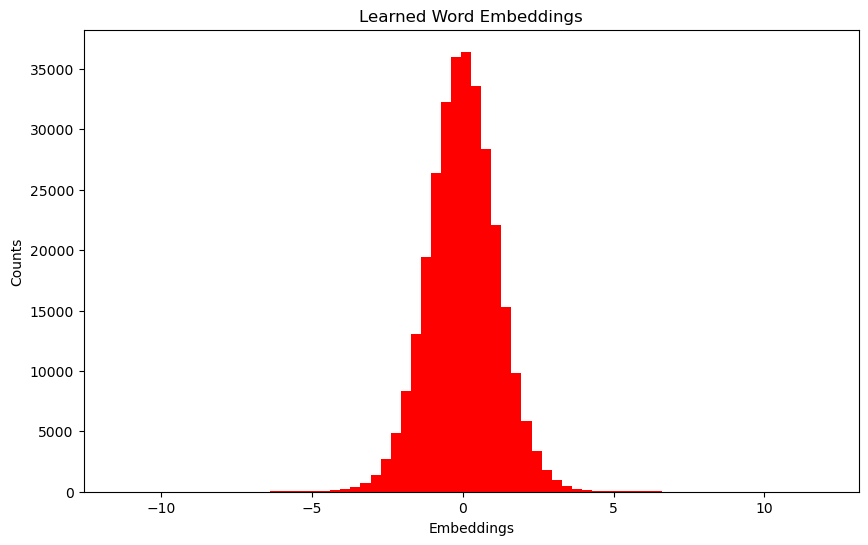

In [39]:
import matplotlib.pyplot as plt


embeddings = model.embed_words.weight.data
plt.figure(figsize=(10, 6))
plt.hist(embeddings.flatten(), bins=70, color='red')
plt.title("Learned Word Embeddings")
plt.xlabel("Embeddings")
plt.ylabel("Counts")
plt.show()


In [2]:
sentiment = load_dataset("yelp_polarity")
tr = sentiment['train']
ts = sentiment['test']
tr = tr.train_test_split(test_size=0.97)['train']
ts = ts.train_test_split(test_size=0.97)['train']

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/opt/anaconda3/envs/compsci371/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def tokenize_function(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512, return_tensors="pt")

In [6]:
tr = tr.map(tokenize_function, batched=True)
tr.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|███████████████████████| 16800/16800 [00:08<00:00, 1869.18 examples/s]


In [7]:
train_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)

In [8]:
ts = ts.map(tokenize_function, batched=True)
ts.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
ts_loader = DataLoader(ts, batch_size=batch_size, shuffle=False)

Map: 100%|█████████████████████████| 1140/1140 [00:00<00:00, 1930.57 examples/s]


In [10]:
optimizer = AdamW(model.parameters(), lr=2e-2)

/opt/anaconda3/envs/compsci371/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(1): 
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")